In [1]:
import copy

from catboost import CatBoostRegressor, CatBoostClassifier
from rdkit import Chem
import numpy as np
import pubchempy as pcp
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader as GraphDataLoader
from sklearn.metrics import mean_squared_error

import src.utils as utils
from src.featurizers import ECFPFeaturizer, GraphFeaturizer
from src.splitters import ScaffoldSplitter
from src.models.gnn import GraphConvolutionalNetwork
from src.early_stopping import EarlyStopping
from src.explanations import plot_grad_cam_explanation, plot_saliency_map_explanation


seed = 1

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
datasets = utils.load_data()
target_fields = utils.get_data_target_field_names()

data, y_col = datasets[0], target_fields[0]

fp_size = 2048
fp_radius = 2
featurizer = ECFPFeaturizer(y_col, length=fp_size, radius=fp_radius, log_target_transform=False)
X, y = featurizer(data)

In [3]:
def create_synthetic_target(
        data,
        mol_mean_and_std,
        default_mean=0.0,
        default_std=1.0
):
    y_synthetic = []
    for mol in data:
        target_value = 0.0
        for mol_to_check in mol_mean_and_std:
            if mol.HasSubstructMatch(Chem.MolFromSmarts(mol_to_check)):
                target_value += np.random.normal(loc=mol_mean_and_std[mol_to_check][0],
                                                    scale=mol_mean_and_std[mol_to_check][1])
        if target_value == 0.0:
            target_value = np.random.normal(loc=default_mean, scale=default_std)
        y_synthetic.append(target_value)
    return np.array(y_synthetic)

# Create synthetic target y
y_synthetic = create_synthetic_target(
    data,
    {
        "c1ccccc1": (1, 0),
    },
    default_mean=0.0,
    default_std=0.0
)
print(y_synthetic)

[1. 0. 1. ... 1. 1. 1.]


In [6]:
data_smiles = [Chem.MolToSmiles(mol) for mol in data]
scaffold_splitter = ScaffoldSplitter()
X_train, X_test, y_train, y_test = scaffold_splitter.train_test_split(X, y_synthetic, data_smiles)

model = CatBoostRegressor(iterations=9999, learning_rate=0.03, max_depth=5,
                           random_state=seed, verbose=100)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)
model.score(X_train, y_train), model.score(X_test, y_test), mean_squared_error(y_test, model.predict(X_test))

0:	learn: 27.9347339	test: 34.9494483	best: 34.9494483 (0)	total: 5.21ms	remaining: 52.1s
100:	learn: 11.5248662	test: 28.6121936	best: 28.6121936 (100)	total: 505ms	remaining: 49.5s
200:	learn: 8.3476378	test: 27.7372984	best: 27.7372984 (200)	total: 993ms	remaining: 48.4s
300:	learn: 6.1561400	test: 27.6703804	best: 27.6460063 (260)	total: 1.47s	remaining: 47.5s
400:	learn: 4.4572927	test: 27.6233408	best: 27.5696054 (341)	total: 1.96s	remaining: 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 27.56960541
bestIteration = 341

Shrink model to first 342 iterations.


(0.9659119825342081, 0.37143186293065567, 760.0831449346628)

In [7]:
top_feature_values = np.argsort(model.feature_importances_)[::-1]
top_feature_values

array([1326,  162,  327, ..., 1323, 1324, 1023], dtype=int64)

In [8]:
model.feature_importances_[top_feature_values][:10]

array([20.15003394,  8.02356295,  7.23449747,  7.03378682,  4.74409922,
        4.73053966,  3.17329229,  2.75367837,  2.66107118,  2.5582841 ])

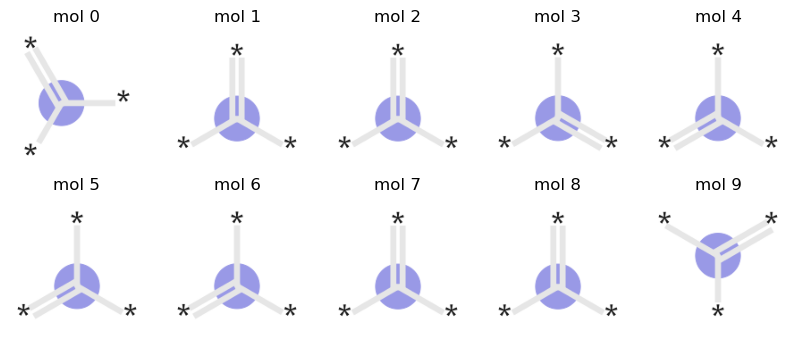

In [9]:
utils.draw_morgan_bit_many_molecules(data, 807, fp_radius, fp_size)

In [10]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def get_morgan_fragment(molecule, bit, radius=2, nBits=2048):
    """
    Returns the molecule fragment corresponding to a given Morgan fingerprint bit.

    Parameters:
    molecule (rdkit.Chem.rdchem.Mol): The molecule to analyze.
    bit (int): The bit of the Morgan fingerprint.
    radius (int): The radius of the Morgan fingerprint. Default is 2.
    nBits (int): The size of the Morgan fingerprint. Default is 2048.

    Returns:
    rdkit.Chem.rdchem.Mol: The fragment corresponding to the given bit.
    """
    # Generate the Morgan fingerprint
    info = {}
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(molecule, radius, nBits=nBits, bitInfo=info)
    
    # Check if the bit is in the fingerprint
    if bit not in info:
        raise ValueError(f"Bit {bit} is not present in the fingerprint.")
    
    # Get the atom indices and radius for the bit
    atom_indices, bit_radius = info[bit][0]
    
    # Get the fragment corresponding to the bit
    env = Chem.FindAtomEnvironmentOfRadiusN(molecule, bit_radius, atom_indices)
    amap = {}
    frag = Chem.PathToSubmol(molecule, env, atomMap=amap)
    
    return frag

# Example usage
mol = data[0]
# TODO doesn't work for single-atom substructures (radius=0)
bit = 118
fragment = get_morgan_fragment(mol, bit)
smiles = Chem.MolToSmiles(fragment)
print(smiles)

CC(C)CN(C)C


In [11]:
# Define the SMILES string
smiles_string = 'CC(C)CN(C)C'

# Search PubChem for the compound
compound = pcp.get_compounds(smiles_string, 'smiles')

# Get the IUPAC name
iupac_name = compound[0].iupac_name if compound else 'Not found'
print(f'IUPAC name: {iupac_name}')

IUPAC name: N,N,2-trimethylpropan-1-amine


### GNN test

In [4]:
splitter = ScaffoldSplitter()
train, test = splitter.train_test_molecules_split(data, y_col)

graph_featurizer = GraphFeaturizer(y_col=y_col, log_target_transform=False)
graph_train = graph_featurizer(train)
graph_test = graph_featurizer(test)

In [24]:
def get_graph_data_with_substituted_target(
        data,
        target
):
    data_copy = copy.deepcopy(data)
    for i in range(len(data_copy)):
        data_copy[i].y = torch.Tensor([target[i]])
    return data_copy


train_synthetic_target = create_synthetic_target(train, {"c1ccccc1": (1, 0)}, default_std=0.0)
test_synthetic_target = create_synthetic_target(test, {"c1ccccc1": (1, 0)}, default_std=0.0)

graph_train_synthetic = get_graph_data_with_substituted_target(graph_train, train_synthetic_target)
graph_test_synthetic = get_graph_data_with_substituted_target(graph_test, test_synthetic_target)

In [25]:
batch_size = 64
graph_train_loader = GraphDataLoader(graph_train_synthetic, batch_size, shuffle=True)
graph_test_loader = GraphDataLoader(graph_test_synthetic, batch_size)

In [26]:
hidden_size = 128
n_layers = 5
model_path = "models/gnn_test_synthetic.pth"
device = "cuda"

gnn = GraphConvolutionalNetwork(graph_train[0].x.shape[1], hidden_size=hidden_size, n_layers=n_layers).to(device)
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
gnn.train_model(graph_train_loader, graph_test_loader, epochs=9999, lr=0.01, early_stopping=early_stopping)
torch.save(gnn.state_dict(), model_path)

Epoch: 0, train loss: 0.3639, test loss: 0.4032
Epoch: 1, train loss: 0.3042, test loss: 0.4933
Epoch: 2, train loss: 0.3114, test loss: 0.4537
Epoch: 3, train loss: 0.2959, test loss: 0.4313
Epoch: 4, train loss: 0.2881, test loss: 0.3762
Epoch: 5, train loss: 0.2369, test loss: 0.3812
Epoch: 6, train loss: 0.2014, test loss: 0.3722
Epoch: 7, train loss: 0.1624, test loss: 0.3314
Epoch: 8, train loss: 0.0892, test loss: 0.3698
Epoch: 9, train loss: 0.0499, test loss: 0.1890
Epoch: 10, train loss: 0.0435, test loss: 0.1665
Epoch: 11, train loss: 0.0336, test loss: 0.1668
Epoch: 12, train loss: 0.0621, test loss: 0.4041
Epoch: 13, train loss: 0.1141, test loss: 0.3567
Epoch: 14, train loss: 0.0653, test loss: 0.1152
Epoch: 15, train loss: 0.0711, test loss: 0.1782
Epoch: 16, train loss: 0.1627, test loss: 0.2294
Epoch: 17, train loss: 0.0915, test loss: 0.2415
Epoch: 18, train loss: 0.0363, test loss: 0.1811
Epoch: 19, train loss: 0.0169, test loss: 1.0380
Epoch: 20, train loss: 0.0396,

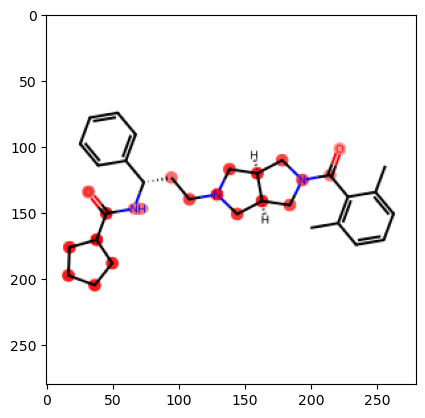

In [41]:
mol_index = 32
plot_grad_cam_explanation(gnn, test[mol_index], graph_test_synthetic[mol_index])
#plot_saliency_map_explanation(gnn, test[mol_index], graph_test_synthetic[mol_index])

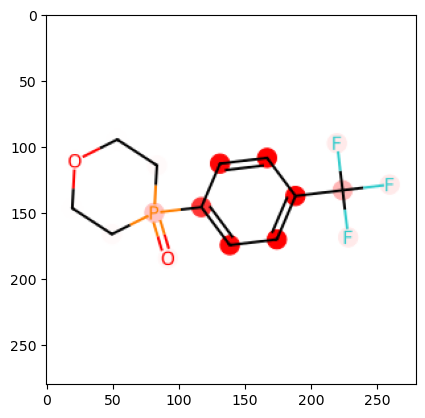

In [45]:
mol_index = 34
plot_saliency_map_explanation(gnn, test[mol_index], graph_test_synthetic[mol_index])

In [23]:
mol_index = 0
print(gnn(graph_test_synthetic[mol_index]))
print(graph_test_synthetic[mol_index].y)

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([1.], device='cuda:0')
